In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary
from utilities import plot_fault_counts, plot_histogram, plot_rose_diagram, append_param_to_cmd, normalize, plot_fault_points, count_pixels   

from tqdm import trange

---

---

# Data Generation

In [2]:
# ─── 0) User picks parameters ────────────────────────────────────────────
mask_mode    = 1 # 0 binary (0, 1) | 1 Multiclass (0, 1, 2), normal and inverse faults
num_pairs    = 10
cube_size    = 128
ricker_freq = (5, 35)      # Hz or (min, max)
seismic_noise = (0.1, 0.5)      # None | float | (min, max)
ricker_dt    = 0.002
wavelet_len  = 0.2        # s
num_gauss    = (2,10)     # int or (min, max)
num_faults = (0,4)       # int or (min, max) faults per cube
max_disp   = (1, 100)   # int or (min, max) max displacement magnitude per cube
strike     = (0,360)      # deg or (min, max) strike angle per fault
dip        = (35,80) # deg or (min, max) dip angle per fault
output_format = "npy" # npy, npz, or dat
train_split = 0.7 # 70% for training
val_split = 0.15 # 15% for validation

In [3]:
# ─── 1) Call your script (passing parameters from notebook variables) ─────────────────
script = "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/synthDataGeneration.py"
base_out = os.path.expanduser("/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data")

# Create output directory if it doesn't exist
os.makedirs(base_out, exist_ok=True)

print(f"Running script: {script}")
print(f"Output directory: {base_out}")

# Calculate the number of samples for each set
num_train = int(np.floor(num_pairs * train_split))
num_val = num_pairs - num_train

# Construct the command
cmd = [
    "python", script,
    "--num-pairs",     str(num_pairs),
    "--size",          str(cube_size),
    "--dt",            str(ricker_dt),
    "--length",        str(wavelet_len),
    "--mask-mode",     str(mask_mode),
    "--format",        output_format,
    "--output-dir",    base_out,
    "--train-split",   str(train_split),
    "--val-split",     str(val_split),
    "--faults",        f"{num_faults[0]},{num_faults[1]}",
    "--max-disp",      f"{max_disp[0]},{max_disp[1]}",
    "--strike",        f"{strike[0]},{strike[1]}",
    "--dip",           f"{dip[0]},{dip[1]}",
    "--freq",          f"{ricker_freq[0]},{ricker_freq[1]}",
    "--num-gaussians", f"{num_gauss[0]},{num_gauss[1]}",
    "--noise",         f"{seismic_noise[0]},{seismic_noise[1]}",
]

# Run the command
result = subprocess.run(cmd, text=True) #result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("Data generation successful!")
    print(result.stdout)
else:
    print("Data generation failed.")
    print(result.stderr)

# Data generation statistics
stats = {
    "total_pairs": num_pairs,
    "train_pairs": num_train,
    "validation_pairs": num_val,
}

# Save statistics to a JSON file
stats_file_path = os.path.join(base_out, "stats_data.json")
with open(stats_file_path, 'w') as f:
    json.dump(stats, f, indent=4)

print(f"Data generation complete. Statistics saved to {stats_file_path}")

Running script: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/synthDataGeneration.py
Output directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data
Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/train
Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/validation

Data split: 7 train, 3 validation.
Output format: npy

Starting data generation for 10 pairs...


Generating Cubes:  90%|█████████ | 9/10 [00:07<00:00,  1.31it/s]


--- Saving Statistics Files ---
Saved full statistics to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_full.json
Saved train statistics to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_train.json
Saved validation statistics to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_validation.json

[2025-07-31 05:25:30] Generation complete.
 • train/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/train/seis
 • train/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/train/fault
 • validation/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/validation/seis
 • validation/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/validation/fault
Done ✅
Data generation successful!
None
Data generation complete. Statistics saved to /home/roderickperez/DS_PROJECTS/faultS

Generating Cubes: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [4]:
# ─── 2) Check the output ────────────────────────────────────────────────
# Check the total number of files created across all splits
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len(os.listdir(seis_dir))

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs.")



Successfully generated 10 file pairs.


In [5]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

append_param_to_cmd(cmd, "freq", ricker_freq)
append_param_to_cmd(cmd, "num-gaussians", num_gauss)
append_param_to_cmd(cmd, "noise", seismic_noise)
append_param_to_cmd(cmd, "faults", num_faults)
append_param_to_cmd(cmd, "max-disp", max_disp)
append_param_to_cmd(cmd, "strike", strike)
append_param_to_cmd(cmd, "dip", dip)

In [6]:
print("\nCommand to run:")
print(" ".join(cmd)) # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")

# Check if the expected number of files were generated
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len([f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat"))])

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs across all splits.")


Command to run:
python /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/synthDataGeneration.py --num-pairs 10 --size 128 --dt 0.002 --length 0.2 --mask-mode 1 --format npy --output-dir /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data --train-split 0.7 --val-split 0.15 --faults 0,4 --max-disp 1,100 --strike 0,360 --dip 35,80 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --faults 0,4 --max-disp 1,100 --strike 0,360 --dip 35,80

Running subprocess...
=== STDOUT ===
 Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/train
Cleaned directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/validation

Data split: 7 train, 3 validation.
Output format: npy

Starting data generation for 10 pairs...

--- Saving Statistics Files ---
Saved full statistics to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_

In [7]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────

# Define the base output directory
#base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Define the splits and their expected number of files
splits = {
    "train": num_train,
    "validation": num_val
}

# Check if the expected number of files were generated for each split
for split, expected_files in splits.items():
    seis_dir = os.path.join(base_out, split, "seis")
    fault_dir = os.path.join(base_out, split, "fault")

    if os.path.exists(seis_dir):
        files = sorted(f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat")))
        n_files = len(files)
        if n_files != expected_files:
            print(f"Warning: Mismatch in generated files for '{split}' split. Expected {expected_files}, found {n_files} in {seis_dir}")
    else:
        print(f"Warning: Seismic output directory not found for '{split}' split: {seis_dir}")

    if not os.path.exists(fault_dir):
        print(f"Warning: Fault output directory not found for '{split}' split: {fault_dir}")

# Load the statistics files
stats_data = {}
for split in splits.keys():
    stats_file_path = os.path.join(base_out, f"statistics_{split}.json")
    if os.path.exists(stats_file_path):
        with open(stats_file_path, 'r') as f:
            stats_data[split] = json.load(f)
            print(f"Successfully loaded statistics for '{split}' split.")
    else:
        print(f"Warning: Statistics file not found for '{split}' split: {stats_file_path}")

# Load the full statistics file
full_stats_path = os.path.join(base_out, "statistics_full.json")
if os.path.exists(full_stats_path):
    with open(full_stats_path, 'r') as f:
        full_stats = json.load(f)
        print("Successfully loaded full statistics.")
else:
    print(f"Warning: Full statistics file not found: {full_stats_path}")

Successfully loaded statistics for 'train' split.
Successfully loaded statistics for 'validation' split.
Successfully loaded full statistics.


In [8]:
# Load all statistics: full, prediction, train, and validation
stats_files = {
    "full": os.path.join(base_out, "statistics_full.json"),
    "train": os.path.join(base_out, "statistics_train.json"),
    "validation": os.path.join(base_out, "statistics_validation.json")
}

all_stats_data = {}
for split, path in stats_files.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                all_stats_data[split] = json.load(f)
            print(f"Loaded statistics for '{split}' from {path}")
        except Exception as e:
            print(f"Error loading statistics for '{split}': {e}")
            all_stats_data[split] = None
    else:
        print(f"Statistics file not found for '{split}': {path}")
        all_stats_data[split] = None

Loaded statistics for 'full' from /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_full.json
Loaded statistics for 'train' from /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_train.json
Loaded statistics for 'validation' from /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/new_data/statistics_validation.json



--- Displaying Statistics and Plots for full data ---


,count,mean,std,min,5%,25%,50%,75%,95%,max,median,% missing
freq,3.000000,26.730000,9.010000,16.980000,18.130000,22.720000,28.470000,31.610000,34.120000,34.740000,28.470000,0.000000
noise_sigma,3.000000,0.270000,0.070000,0.230000,0.230000,0.230000,0.240000,0.300000,0.340000,0.360000,0.240000,0.000000
num_gaussians,3.000000,6.000000,3.610000,2.000000,2.500000,4.500000,7.000000,8.000000,8.800000,9.000000,7.000000,0.000000
num_faults_generated,3.000000,3.330000,1.150000,2.000000,2.200000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max_disp_used,3.000000,65.330000,19.730000,52.000000,52.400000,54.000000,56.000000,72.000000,84.800000,88.000000,56.000000,0.000000



Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.38 %
      normal:   0.64 %
     inverse:   0.98 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.38 %
      normal:   0.64 %
     inverse:   0.98 %


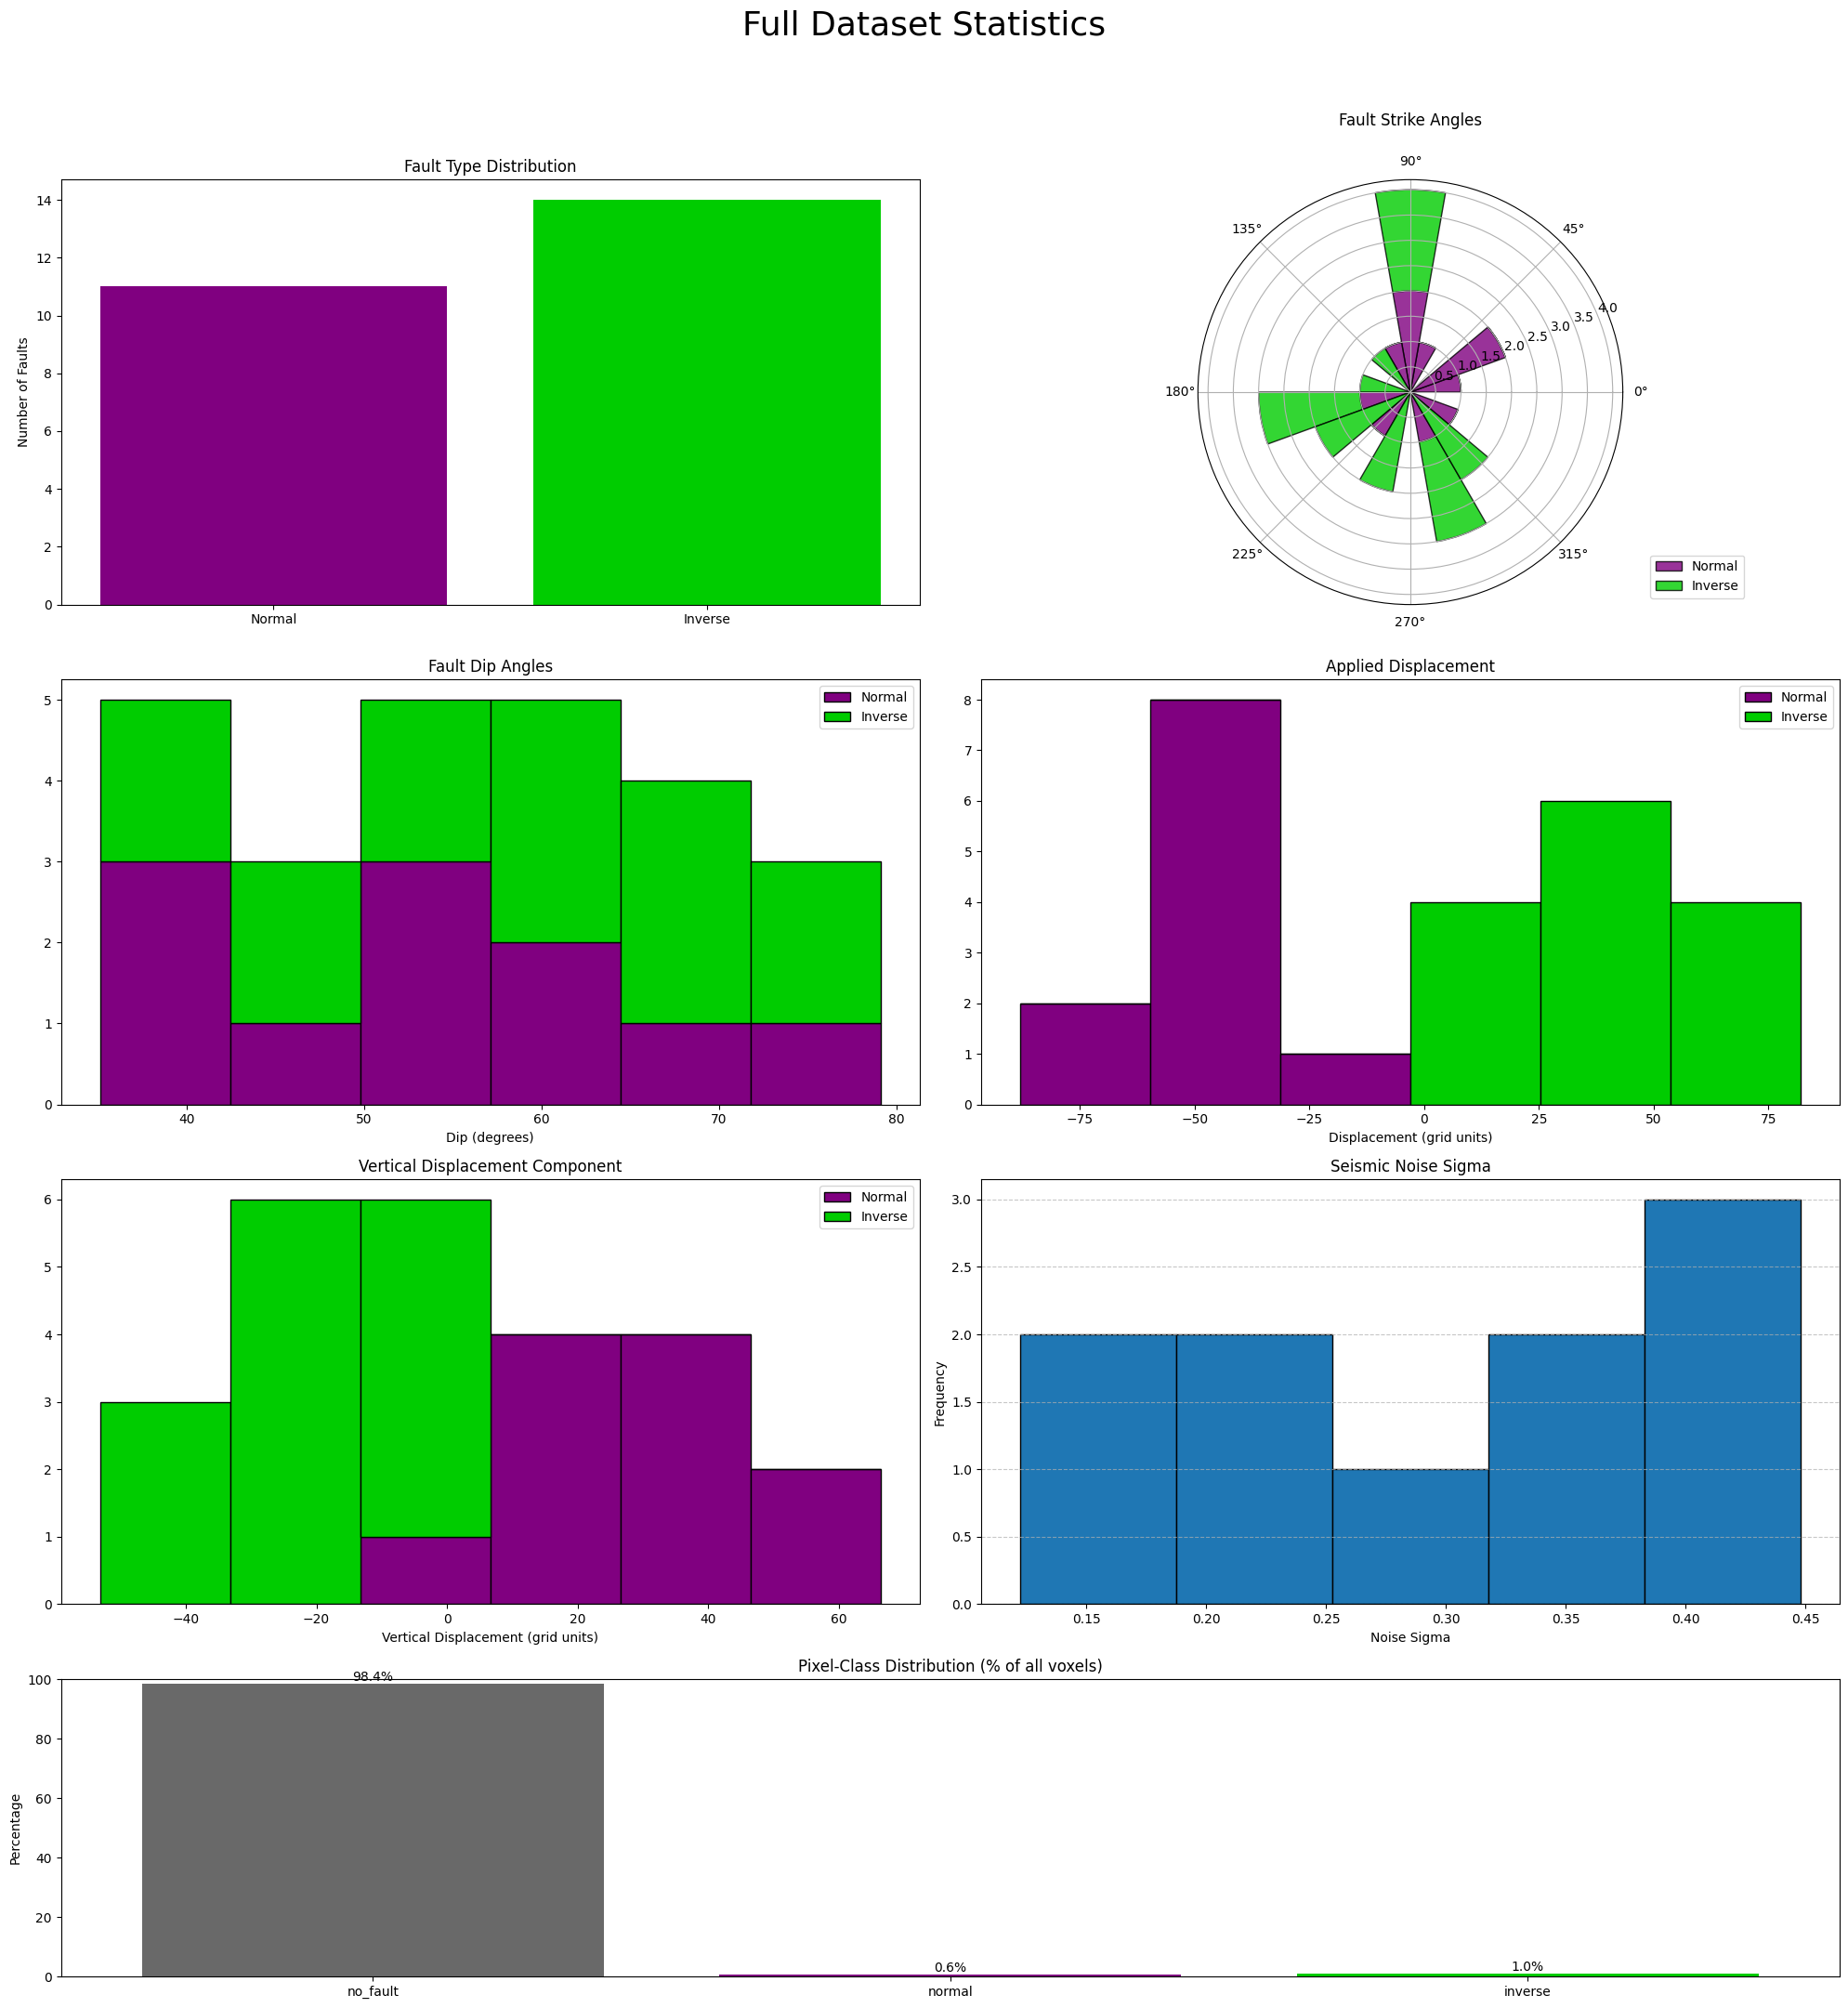


--- Displaying Statistics and Plots for train data ---


,count,mean,std,min,5%,25%,50%,75%,95%,max,median,% missing
freq,10.000000,21.340000,9.120000,8.900000,10.370000,13.960000,20.270000,27.700000,34.180000,34.740000,20.270000,0.000000
noise_sigma,10.000000,0.300000,0.110000,0.120000,0.150000,0.230000,0.320000,0.390000,0.430000,0.450000,0.320000,0.000000
num_gaussians,10.000000,6.100000,3.000000,2.000000,2.000000,3.500000,6.500000,8.750000,9.550000,10.000000,6.500000,0.000000
num_faults_generated,10.000000,2.500000,1.430000,0.000000,0.450000,1.250000,3.000000,3.750000,4.000000,4.000000,3.000000,0.000000
max_disp_used,10.000000,50.900000,26.480000,7.000000,14.650000,35.000000,49.000000,74.000000,85.300000,88.000000,49.000000,0.000000



Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.46 %
      normal:   0.58 %
     inverse:   0.96 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.46 %
      normal:   0.58 %
     inverse:   0.96 %


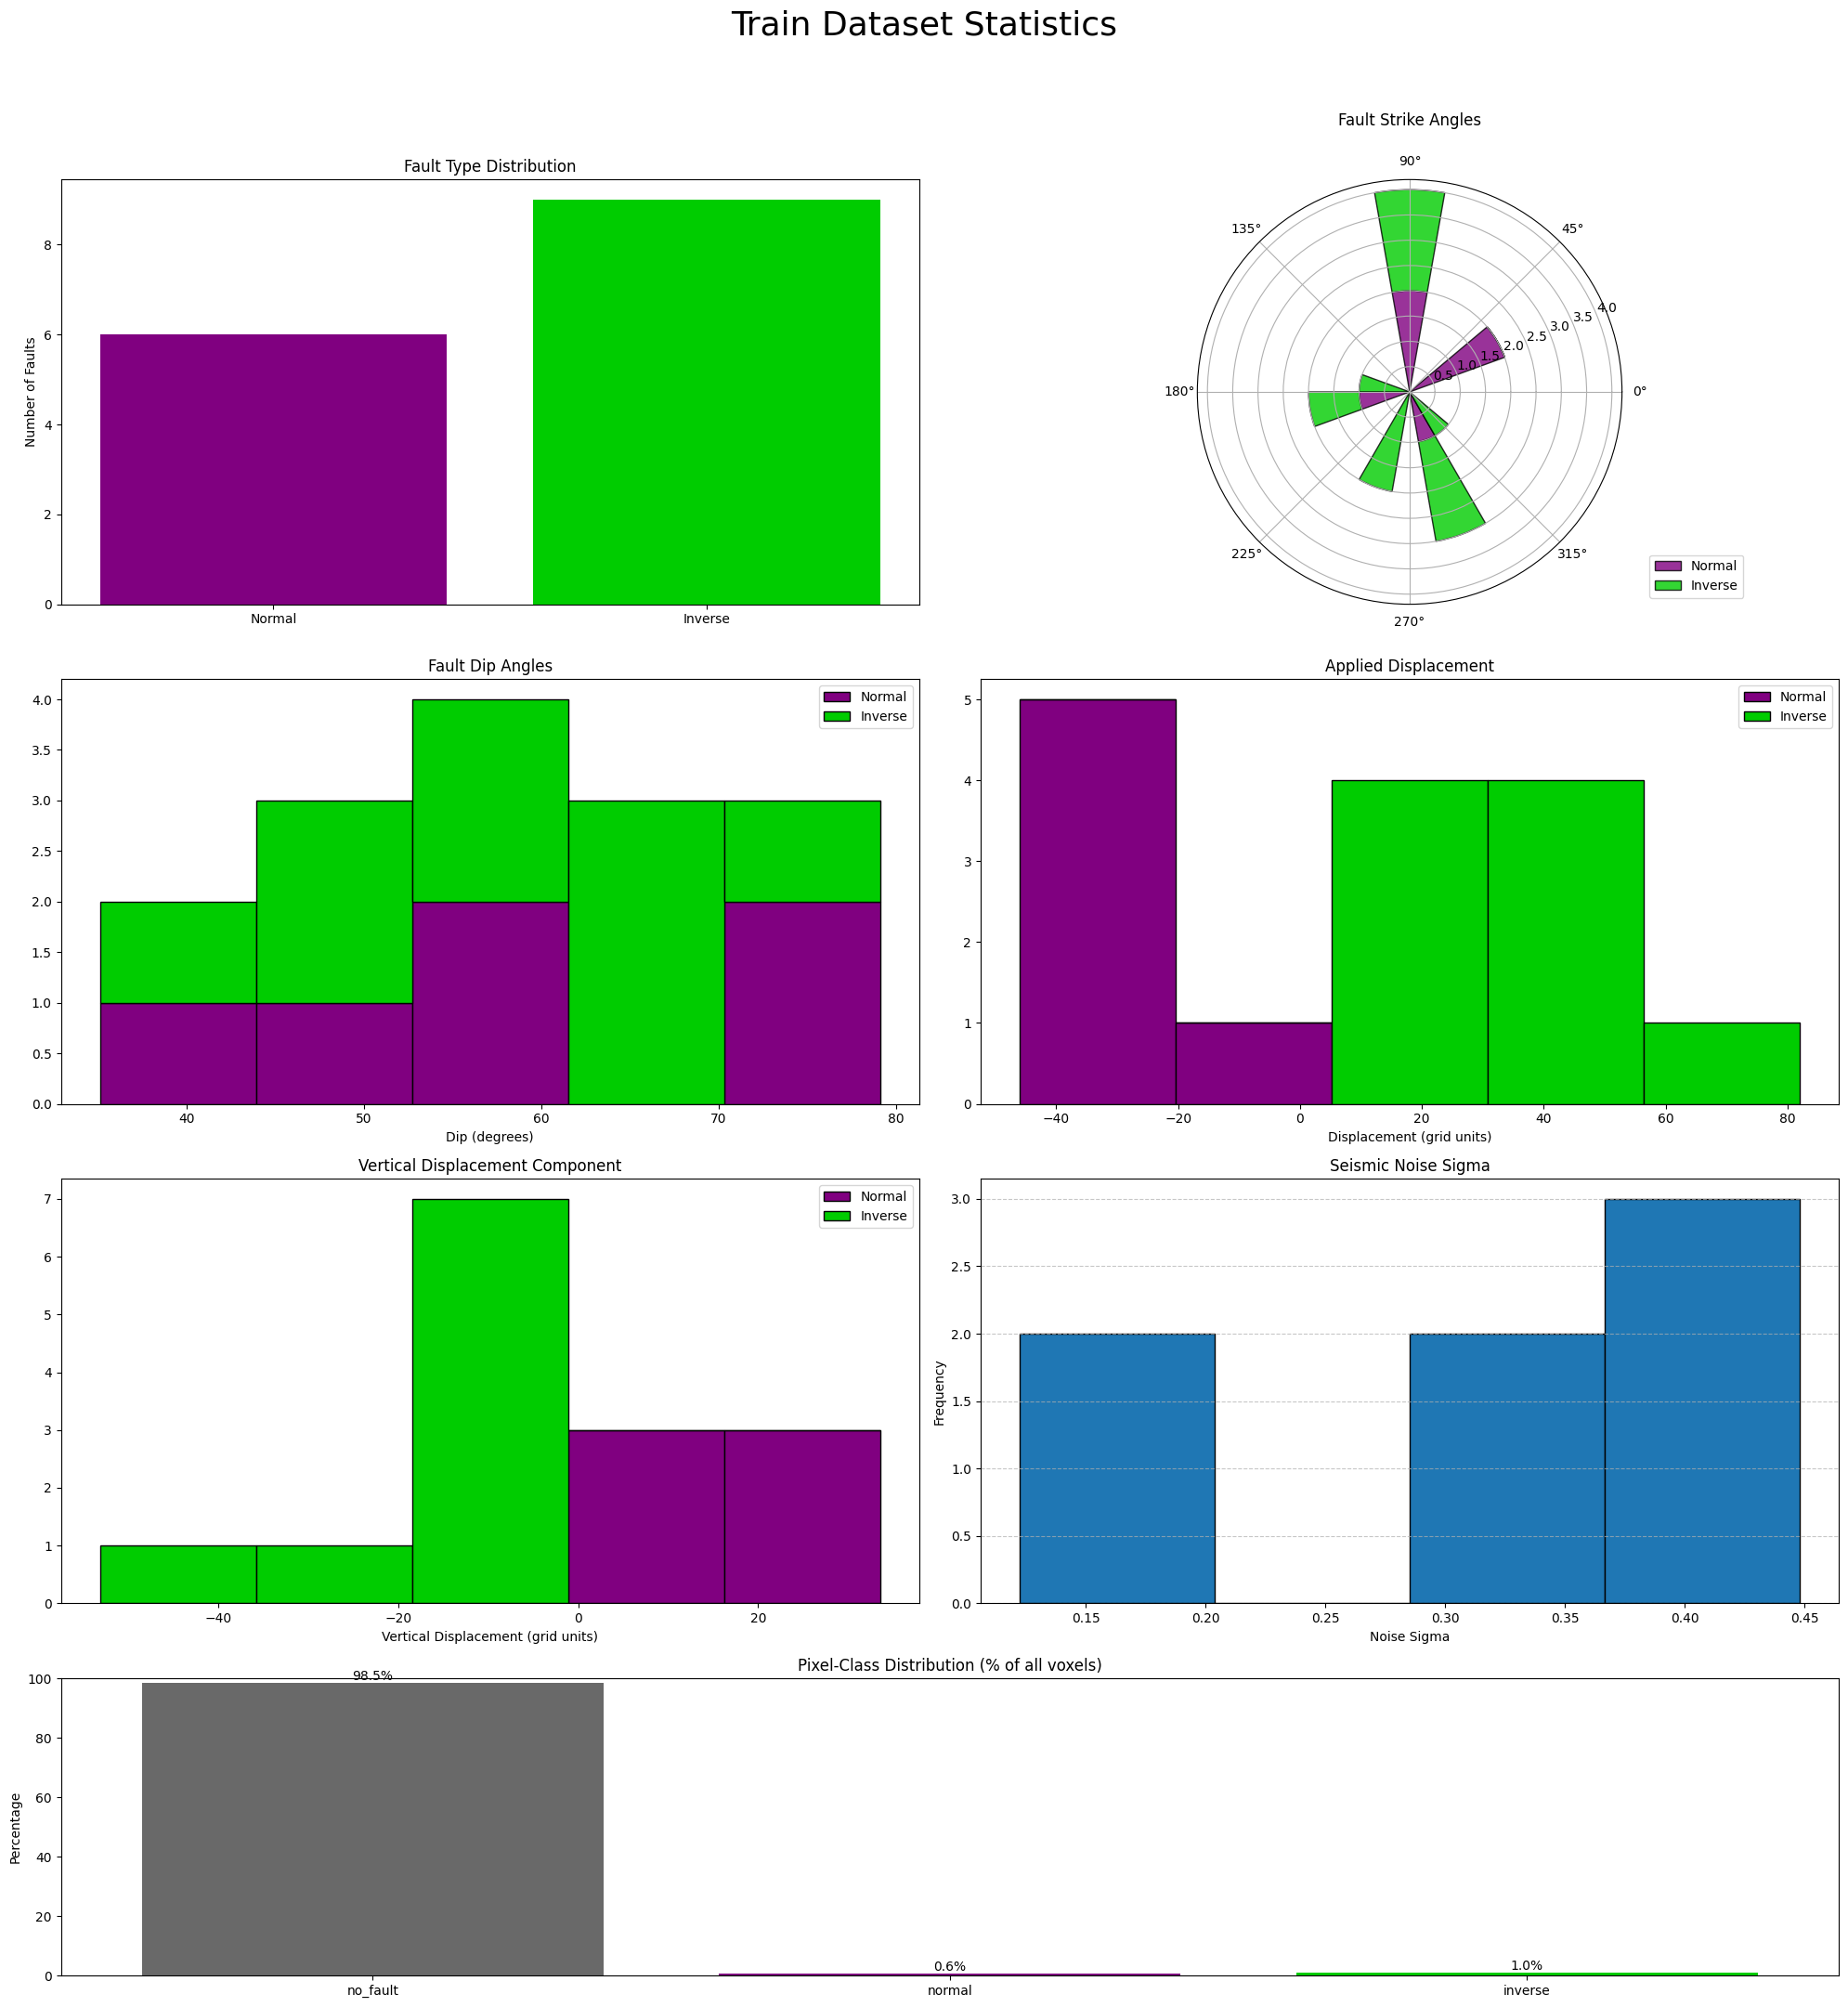


--- Displaying Statistics and Plots for validation data ---


,count,mean,std,min,5%,25%,50%,75%,95%,max,median,% missing
freq,7.000000,19.030000,8.770000,8.900000,9.880000,12.630000,16.590000,24.490000,31.070000,33.500000,16.590000,0.000000
noise_sigma,7.000000,0.310000,0.120000,0.120000,0.140000,0.240000,0.340000,0.410000,0.440000,0.450000,0.340000,0.000000
num_gaussians,7.000000,6.140000,3.020000,2.000000,2.300000,4.000000,6.000000,8.500000,9.700000,10.000000,6.000000,0.000000
num_faults_generated,7.000000,2.140000,1.460000,0.000000,0.300000,1.000000,3.000000,3.000000,3.700000,4.000000,3.000000,0.000000
max_disp_used,7.000000,44.710000,27.810000,7.000000,12.100000,28.500000,41.000000,63.000000,81.400000,82.000000,41.000000,0.000000



Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  98.21 %
      normal:   0.78 %
     inverse:   1.01 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  98.21 %
      normal:   0.78 %
     inverse:   1.01 %


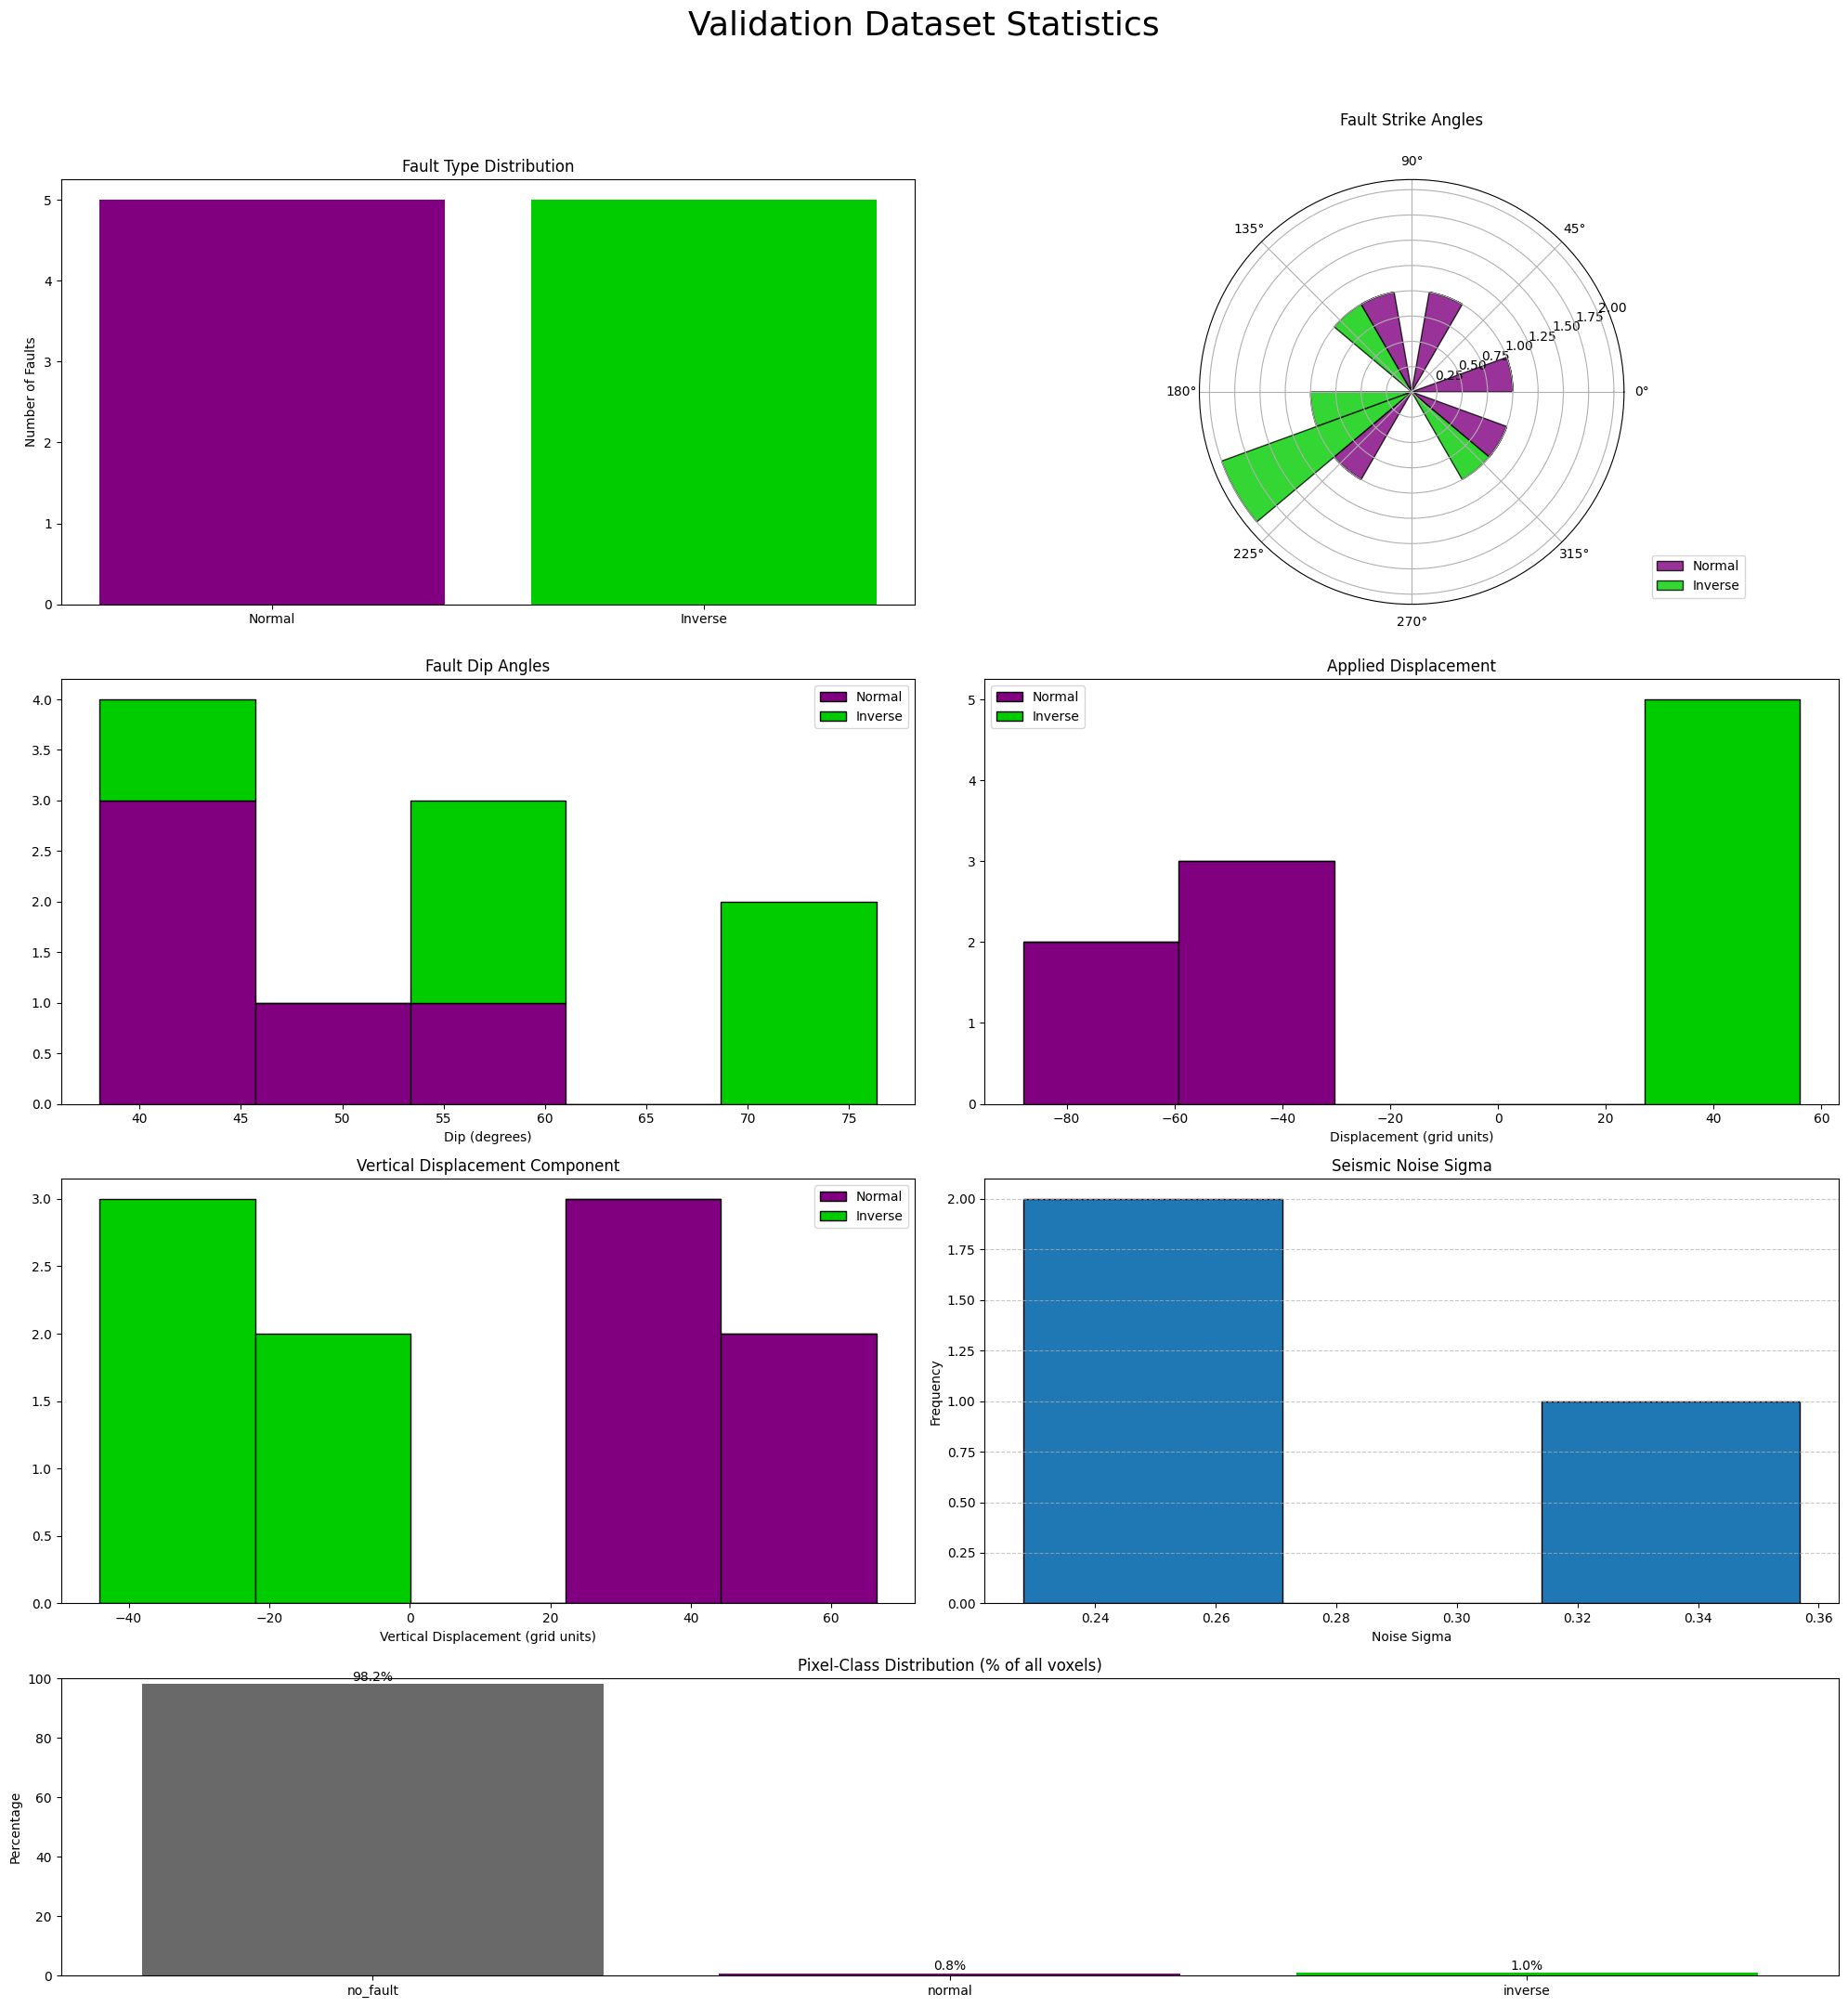

In [ ]:
# ─── 3) Display Statistics and Plots for All Splits Individually ──────────────────────────────

# palette for stacked plots
normal_colour  = (0.50, 0.00, 0.50)   # purple  (Normal)
inverse_colour = (0.00, 0.80, 0.00)   # green   (Inverse)
    
for split_name in ['full', 'train', 'validation']:
    stats = all_stats_data.get(split_name)
    print(f"\n--- Displaying Statistics and Plots for {split_name} data ---")

    if not stats or 'cube_level_params' not in stats or 'all_fault_params' not in stats:
        print(f"No statistics available for '{split_name}' split.")
        continue

    # Extract parameters for the current split
    cube_level_params = stats['cube_level_params']
    all_fault_params  = stats['all_fault_params']

    # Create a summary DataFrame
    df = pd.DataFrame(cube_level_params)
    print("\nCube Generation Parameter Summary:")
    print(df.describe())

    # ------------------------------------------------------------------
    # NEW ─ gather all mask cubes for pixel-class statistics
    # ------------------------------------------------------------------
    mask_cubes = []
    splits_to_scan = ['train', 'validation'] if split_name == 'full' else [split_name]
    for split_dir in splits_to_scan:
        mdir = os.path.join(base_out, split_dir, "fault")
        if not os.path.isdir(mdir):
            continue
        for fname in sorted(os.listdir(mdir)):
            if not fname.endswith((".npy", ".dat")):
                continue
            fpath = os.path.join(mdir, fname)
            if fname.endswith(".npy"):
                mask_cubes.append(np.load(fpath))
            else:  # .dat
                mask_cubes.append(np.fromfile(fpath, dtype=np.uint8)
                                  .reshape((cube_size,)*3))

    overall_pct, mean_pct = count_pixels(mask_cubes, mask_mode)

    print("\nPixel-class distribution – OVERALL (% of all voxels):")
    for k, v in overall_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")
    print("Pixel-class distribution – MEAN PER CUBE:")
    for k, v in mean_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")

    # --- Generate and Display Plots ---
    if not all_fault_params:
        print("\nNo fault parameters to plot for this split.")
        continue

    # Extract fault-specific data for plotting
    strikes               = [f['strike'] for f in all_fault_params]
    dips                  = [f['dip'] for f in all_fault_params]
    displacements         = [f['applied_disp_signed']     for f in all_fault_params]
    vertical_displacements= [f['vertical_disp_component'] for f in all_fault_params]
    noise_sigmas          = [p.get('noise_sigma')         for p in cube_level_params]

    # Create a figure with a grid of subplots  (NOW 4×2)
    fig = plt.figure(figsize=(20, 22))
    fig.suptitle(f"{split_name.capitalize()} Dataset Statistics", fontsize=26)
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 0.7])

    # Plot Fault Counts
    ax1 = fig.add_subplot(gs[0, 0])

    if mask_mode == 0:
        # binary → one bar
        ax1.bar(['Total'],
                [len(all_fault_params)],
                color=['skyblue'])
    else:
        # multiclass → two bars (Normal, Inverse)
        normal_count  = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
        inverse_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')
        ax1.bar(['Normal', 'Inverse'],
                [normal_count, inverse_count],
                color=[normal_colour, inverse_colour])

    ax1.set_title('Fault Type Distribution')
    ax1.set_ylabel('Number of Faults')

    # Plot Strike Rose Diagram
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    if strikes:
        if mask_mode == 1:
            # --- separate angles
            strikes_normal  = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Normal'])
            strikes_inverse = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Inverse'])

            num_bins = 18
            bins_rad = np.linspace(0, 2*np.pi, num_bins + 1)
            cnt_norm , _ = np.histogram(strikes_normal , bins=bins_rad)
            cnt_inv  , _ = np.histogram(strikes_inverse, bins=bins_rad)

            centres = bins_rad[:-1] + np.diff(bins_rad)/2
            width   = np.diff(bins_rad)[0]

            # first ring = Normal
            ax2.bar(centres, cnt_norm,
                    width=width,
                    bottom=0.0,
                    color=normal_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Normal')
            # stacked on top = Inverse
            ax2.bar(centres, cnt_inv,
                    width=width,
                    bottom=cnt_norm,
                    color=inverse_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Inverse')

            ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))
            ax2.set_title('Fault Strike Angles', va='bottom', y=1.1)
        else:
            plot_rose_diagram(strikes, ax=ax2, title='Fault Strike Angles')

    # Plot Dip Histogram
    ax3 = fig.add_subplot(gs[1, 0])

    if dips:
        if mask_mode == 1:
            dips_normal  = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Normal']
            dips_inverse = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax3.hist([dips_normal, dips_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax3.legend()
        else:
            plot_histogram(dips, ax=ax3, title='Fault Dip Angles',
                           xlabel='Dip (degrees)')
        ax3.set_title('Fault Dip Angles')
        ax3.set_xlabel('Dip (degrees)')

    # Plot Displacement Histogram
    ax4 = fig.add_subplot(gs[1, 1])
    if displacements:
        if mask_mode == 1:
            disp_normal  = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Normal']
            disp_inverse = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax4.hist([disp_normal, disp_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax4.legend()
        else:
            plot_histogram(displacements, ax=ax4, title='Applied Displacement',
                           xlabel='Displacement (grid units)')
        ax4.set_title('Applied Displacement')
        ax4.set_xlabel('Displacement (grid units)')

    # Plot Vertical Displacement Histogram
    ax5 = fig.add_subplot(gs[2, 0])
    if vertical_displacements:
        if mask_mode == 1:
            vdisp_normal  = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Normal']
            vdisp_inverse = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax5.hist([vdisp_normal, vdisp_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax5.legend()
        else:
            plot_histogram(vertical_displacements, ax=ax5,
                           title='Vertical Displacement Component',
                           xlabel='Vertical Displacement (grid units)')
        ax5.set_title('Vertical Displacement Component')
        ax5.set_xlabel('Vertical Displacement (grid units)')

    # Plot Noise Sigma Histogram
    ax6 = fig.add_subplot(gs[2, 1])
    if any(n is not None for n in noise_sigmas):
        plot_histogram([n for n in noise_sigmas if n is not None],
                       ax=ax6, title='Seismic Noise Sigma',
                       xlabel='Noise Sigma')

    # ------------------------------------------------------------------
    # NEW subplot: pixel-class distribution
    # ------------------------------------------------------------------
    ax7 = fig.add_subplot(gs[3, :])
    categories = list(overall_pct.keys())

    if mask_mode == 0:
        colours = ['dimgrey', 'skyblue'][:len(categories)]
    else:
        colour_map = {
            'no_fault': 'dimgrey',
            'normal'  : (0.50, 0.00, 0.50),  # purple
            'inverse' : (0.00, 0.80, 0.00)   # green
        }
        colours = [colour_map[c] for c in categories]

    ax7.bar(categories,
            [overall_pct[k] for k in categories],
            color=colours)
    ax7.set_ylim(0, 100)
    ax7.set_title('Pixel-Class Distribution (% of all voxels)')
    ax7.set_ylabel('Percentage')
    for i, k in enumerate(categories):
        ax7.text(i, overall_pct[k] + 1, f"{overall_pct[k]:.1f}%", ha='center')


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


---

In [10]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

---

---

### 3D Visualization

In [11]:
# PARAMETERS
# cube_size = 128  # or whatever you used
# mask_mode = 1    # or 1
#base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

In [12]:
# Function to normalize to 0-255 uint8
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Function to plot fault points
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))

In [13]:
# PARAMETERS
# cube_size = 128  # Adjust as needed
# mask_mode = 1    # 0 = binary masks; 1 = multiclass
#base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

# Normalization helper
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Fault plotting function
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))

# Loop over splits
for split in ["train", "validation"]:
    seismic_dir = os.path.join(base_out, split, "seis")
    mask_dir = os.path.join(base_out, split, "fault")

    if not (os.path.exists(seismic_dir) and os.path.exists(mask_dir)):
        print(f"[{split}] Skipping: directories not found.")
        continue

    files = sorted(set(os.listdir(seismic_dir)).intersection(os.listdir(mask_dir)))
    if not files:
        print(f"[{split}] No files to visualize.")
        continue

    selected_file = random.choice([f for f in files if f.endswith((".npy", ".dat"))])
    print(f"[{split}] Selected file: {selected_file}")

    # Load data
    seismic_path = os.path.join(seismic_dir, selected_file)
    mask_path = os.path.join(mask_dir, selected_file)

    if selected_file.endswith(".npy"):
        seismic = np.load(seismic_path)
        mask = np.load(mask_path)
    else:
        seismic = np.fromfile(seismic_path, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
        mask = np.fromfile(mask_path, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))

    nx, ny, nz = seismic.shape

    # Slices
    inline     = seismic[nx//2,:,:].T
    crossline  = seismic[:,ny//2,:].T
    timeslice  = seismic[:,:,nz//2]

    inline_m   = mask[nx//2,:,:].T
    cross_m    = mask[:,ny//2,:].T
    timeslice_m= mask[:,:,nz//2]

    inline_norm    = normalize(inline)
    crossline_norm = normalize(crossline)
    timeslice_norm = normalize(timeslice)

    # Create 3D figure
    fig = go.Figure()

    # Seismic surfaces
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (ny, 1)).T,
        x=np.full((nz, ny), nx//2),
        y=np.tile(np.arange(ny), (nz, 1)),
        surfacecolor=inline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (nx, 1)).T,
        x=np.tile(np.arange(nx), (nz, 1)),
        y=np.full((nz, nx), ny//2),
        surfacecolor=crossline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.full((ny, nx), nz//2),
        x=np.tile(np.arange(nx), (ny, 1)),
        y=np.tile(np.arange(ny).reshape(-1,1), (1, nx)),
        surfacecolor=np.rot90(timeslice_norm, k=-1),
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))

    # Fault overlays
    if mask_mode == 0:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "white", "Inline Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "white", "Crossline Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "white", "Time-Slice Faults", nx, ny, nz)
    elif mask_mode == 1:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "green", "Inline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, inline_m==2, nx//2, "inline", "purple", "Inline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "green", "Crossline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==2, ny//2, "crossline", "purple", "Crossline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "green", "Time-Slice Normal Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==2, nz//2, "timeslice", "purple", "Time-Slice Inverse Faults", nx, ny, nz)

    # Layout
    fig.update_layout(
        title=f"3D Fault Visualization — {split.upper()} / {selected_file}",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

[train] Selected file: 0.npy


[validation] Selected file: 6.npy
